# レンタル自転車の利用者数予測  
2年間の季節情報や気象情報から、各日の1時間ごとのレンタル自転車の利用者数を予測

ライブラリインポート

In [2]:
import pandas as pd
import numpy as np

#import pycaret

#setup関数をimport
#from pycaret.regression import setup

#compare_models関数は、ライブラリ内のすべてのモデルを使って訓練を行い、スコアを評価する。
#回帰問題なので'refression'を指定
#from pycaret.regression import compare_models

#models関数により、すべての使用可能な機械学習モデルを確認できる。
#from pycaret.regression import models

#ceate_model関数:「交差検証」を用いて個別のモデルの訓練と評価を行う。  
#from pycaret.regression import create_model

#tune_model関数を用いて、ハイパーパラメータを最適化する。
#from pycaret.regression import tune_model

#plot_model関数を使い、各特徴量の重要度をプロットする、
#from pycaret.regression import plot_model

#finalize_model関数により、すべての訓練データを使ってモデルを訓練し、本番用のモデルを作成できるようにする。
#from pycaret.regression import finalize_model

#from pycaret.regression import predict_model

import lightgbm as lgb
from sklearn import metrics
from scipy.stats import rankdata
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.simplefilter('ignore', FutureWarning)

import re
import pickle
import seaborn as sns
import lightgbm as lgb
#import japanize_matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import copy

データ概要

課題種別：時系列  
データ種別：多変量  
学習データサンプル数：8645  
説明変数の数：13  
欠損値：無し

## trainデータ概要

0	id:  
1	dteday:日付（2011-01-01～2012-12-31）  
2	season:季節（1=春, 2=夏, 3=秋, 4=冬）  
3	yr:年（0=2011, 1=2012）  
4	mnth:月  
5	hr:時間  
6	holiday:祝日（1=祝日）  
7	weekday:曜日（0=日, 1=月...6=土）  
8	workingday:平日（0=平日, 1=祝日）  
9	weathersit:天気（1=晴,やや曇り, 2=薄い霧+曇り,霧+千切れ曇,霧+やや曇り,薄い霧, 3=小雪,小雨+雷雨+千切れ曇,小雨+千切れ曇, 4=大雨+凍雨+雷雨+霧,雪+濃い霧）  
10	temp:規格化した温度（摂氏）（（t-t_min）/（t_max-t_min）, t_min=-8, t_max=+39）  
11	atemp:規格化した体感温度（摂氏）（（t-t_min）/（t_max-t_min）, t_min=-16, t_max=+50） 
12	hum:規格化した湿度（最大値の100で割った値）  
13	windspeed:規格化した風速（最大値の67で割った値）  
14	cnt:利用者数

In [5]:
train_df = pd.read_table('train.tsv')
train_df.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8645 entries, 0 to 8644
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8645 non-null   int64  
 1   dteday      8645 non-null   object 
 2   season      8645 non-null   int64  
 3   yr          8645 non-null   int64  
 4   mnth        8645 non-null   int64  
 5   hr          8645 non-null   int64  
 6   holiday     8645 non-null   int64  
 7   weekday     8645 non-null   int64  
 8   workingday  8645 non-null   int64  
 9   weathersit  8645 non-null   int64  
 10  temp        8645 non-null   float64
 11  atemp       8645 non-null   float64
 12  hum         8645 non-null   float64
 13  windspeed   8645 non-null   float64
 14  cnt         8645 non-null   int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 1013.2+ KB


In [9]:
train_df.isnull().sum()

id            0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [11]:
train_df.describe()

,id,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,8645.000000,8645.000000,8645.0,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.000000,8645.00000,8645.000000,8645.000000,8645.000000
mean,4323.000000,2.513592,0.0,6.573973,11.573626,0.027646,3.012724,0.683748,1.437594,0.489069,0.46900,0.643430,0.191172,143.794448
std,2495.740872,1.105477,0.0,3.428147,6.907822,0.163966,2.006370,0.465040,0.653859,0.197943,0.17676,0.196293,0.123191,133.797854
min,1.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.00000,0.000000,0.000000,1.000000
25%,2162.000000,2.000000,0.0,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.320000,0.31820,0.490000,0.104500,31.000000
50%,4323.000000,3.000000,0.0,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.48480,0.650000,0.194000,109.000000
75%,6484.000000,3.000000,0.0,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.62120,0.810000,0.283600,211.000000
max,8645.000000,4.000000,0.0,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.960000,1.00000,1.000000,0.850700,651.000000


## testデータ概要

In [8]:
test_df = pd.read_table('test.tsv')
test_df.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8734 entries, 0 to 8733
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8734 non-null   int64  
 1   dteday      8734 non-null   object 
 2   season      8734 non-null   int64  
 3   yr          8734 non-null   int64  
 4   mnth        8734 non-null   int64  
 5   hr          8734 non-null   int64  
 6   holiday     8734 non-null   int64  
 7   weekday     8734 non-null   int64  
 8   workingday  8734 non-null   int64  
 9   weathersit  8734 non-null   int64  
 10  temp        8734 non-null   float64
 11  atemp       8734 non-null   float64
 12  hum         8734 non-null   float64
 13  windspeed   8734 non-null   float64
dtypes: float64(4), int64(9), object(1)
memory usage: 955.4+ KB


In [13]:
test_df.isnull().sum()

id            0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64

In [14]:
test_df.describe()

,id,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
count,8734.000000,8734.000000,8734.0,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000
mean,13012.500000,2.489810,1.0,6.501946,11.520151,0.029883,2.994733,0.681704,1.413098,0.504825,0.482481,0.611193,0.189034
std,2521.432959,1.108279,0.0,3.449086,6.921208,0.170275,2.005254,0.465842,0.624470,0.186752,0.166587,0.188184,0.121490
min,8646.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.015200,0.160000,0.000000
25%,10829.250000,2.000000,1.0,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.460000,0.104500
50%,13012.500000,2.000000,1.0,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.520000,0.484800,0.610000,0.164200
75%,15195.750000,3.000000,1.0,9.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.770000,0.253700
max,17379.000000,4.000000,1.0,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.924200,1.000000,0.806000


# 前処理等

### trainデータの加工

In [15]:
#売上日の列を日時型に変換して置き換え
train_df['dteday'] = pd.to_datetime(train_df['dteday'])
train_df.dtypes

id                     int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
dtype: object

In [16]:
#'date'列をインデックスに入れる。
train_df = train_df.set_index('dteday')
train_df.head()

,id,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
dteday,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
2011-01-01,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2011-01-01,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
2011-01-01,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
2011-01-01,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8645 entries, 2011-01-01 to 2011-12-31
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8645 non-null   int64  
 1   season      8645 non-null   int64  
 2   yr          8645 non-null   int64  
 3   mnth        8645 non-null   int64  
 4   hr          8645 non-null   int64  
 5   holiday     8645 non-null   int64  
 6   weekday     8645 non-null   int64  
 7   workingday  8645 non-null   int64  
 8   weathersit  8645 non-null   int64  
 9   temp        8645 non-null   float64
 10  atemp       8645 non-null   float64
 11  hum         8645 non-null   float64
 12  windspeed   8645 non-null   float64
 13  cnt         8645 non-null   int64  
dtypes: float64(4), int64(10)
memory usage: 1013.1 KB


1日が1時間ごとに24分割されているので、月や年で分けてもうまく予測出来なそう。  
期間で区切らずに、単純にlightGBMやdeeplearnigしてもいいかも

In [21]:
#trainデータをid以外を取り出す。
train_df = train_df[['season','yr','mnth','hr','holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed','cnt']]
train_df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
dteday,,,,,,,,,,,,,
2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


### データの可視化

<AxesSubplot:xlabel='dteday'>

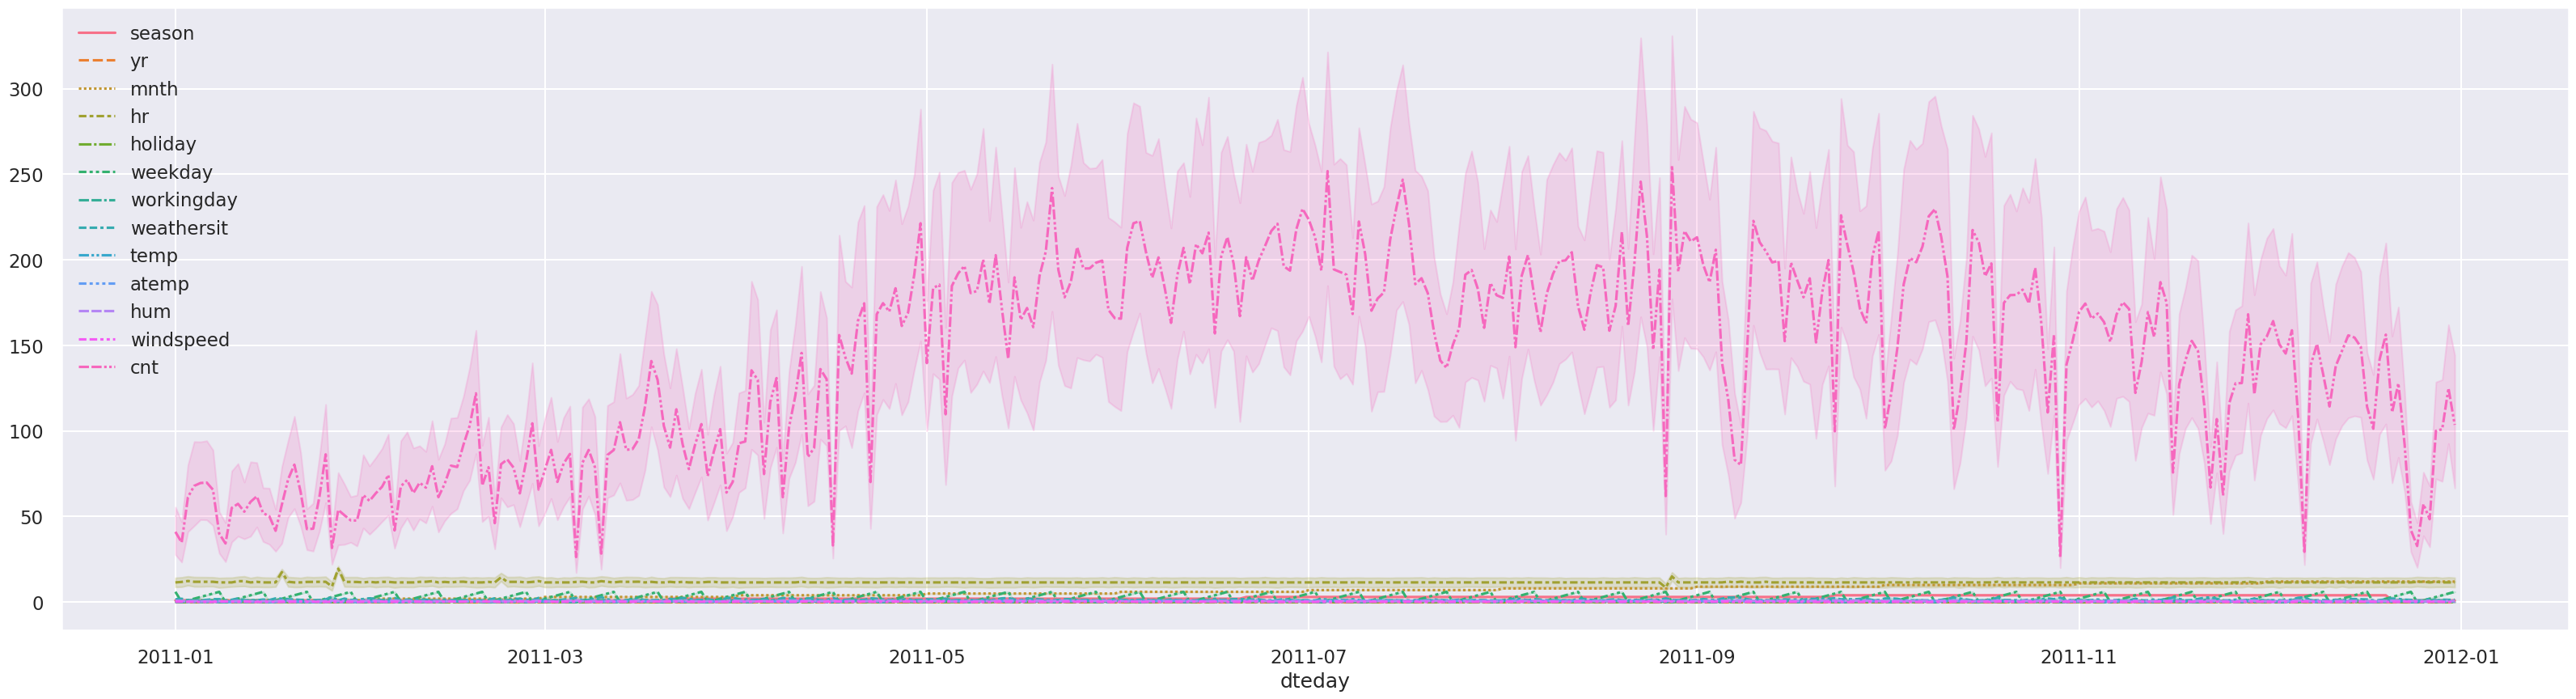

In [22]:
#折れ線グラフ

#見やすくする設定
sns.set(context='talk',font='Hiragino Maru Gothic Pro')
fig = plt.subplots(figsize=(40,10))

#全ての日時のデータを表示 
sns.lineplot(data=train_df)

細かすぎてよくわからない。

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

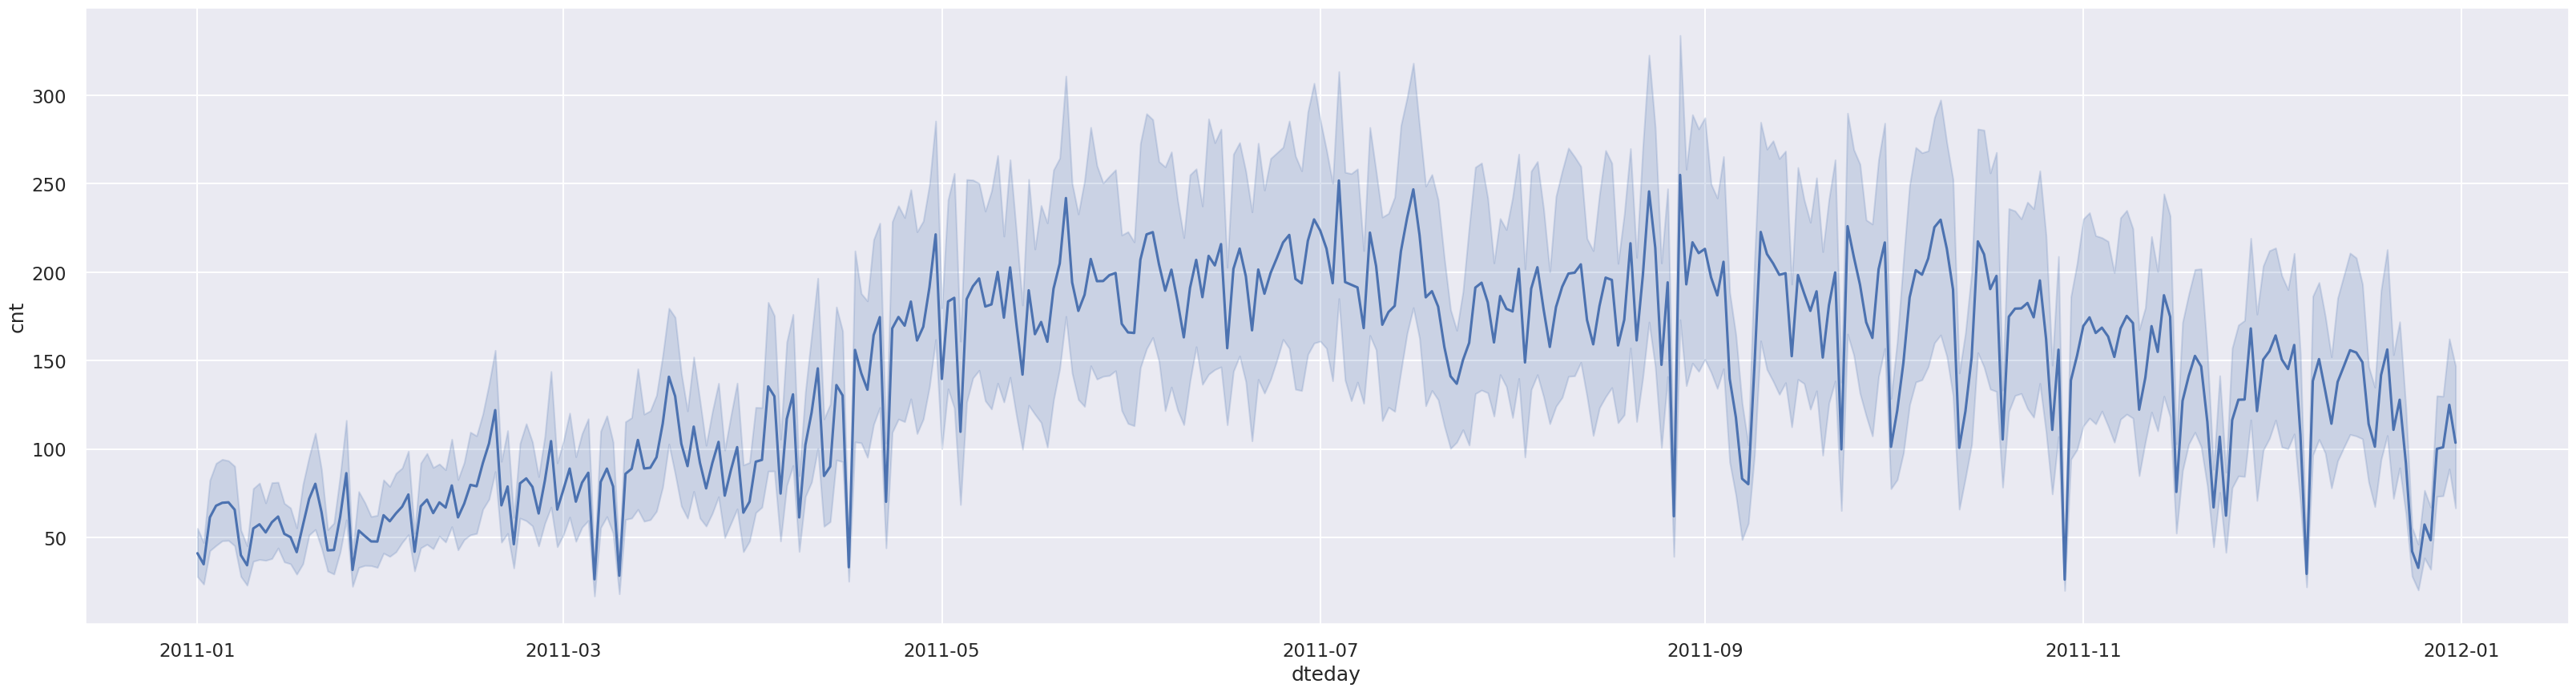

In [23]:
#折れ線グラフ

#見やすくする設定
sns.set(context='talk',font='Hiragino Maru Gothic Pro')
fig = plt.subplots(figsize=(40,10))

#全ての日時を表示 
sns.lineplot(data=train_df['cnt'])

なんとなく周期性が見られる。  
5月~11月ごろの利用は他の月より多そう。

#### 期間ごとの周期性を可視化

In [31]:
#月ごとの売上金額の合計を表示
train_month_df = train_df.set_index(train_df.index.month)

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

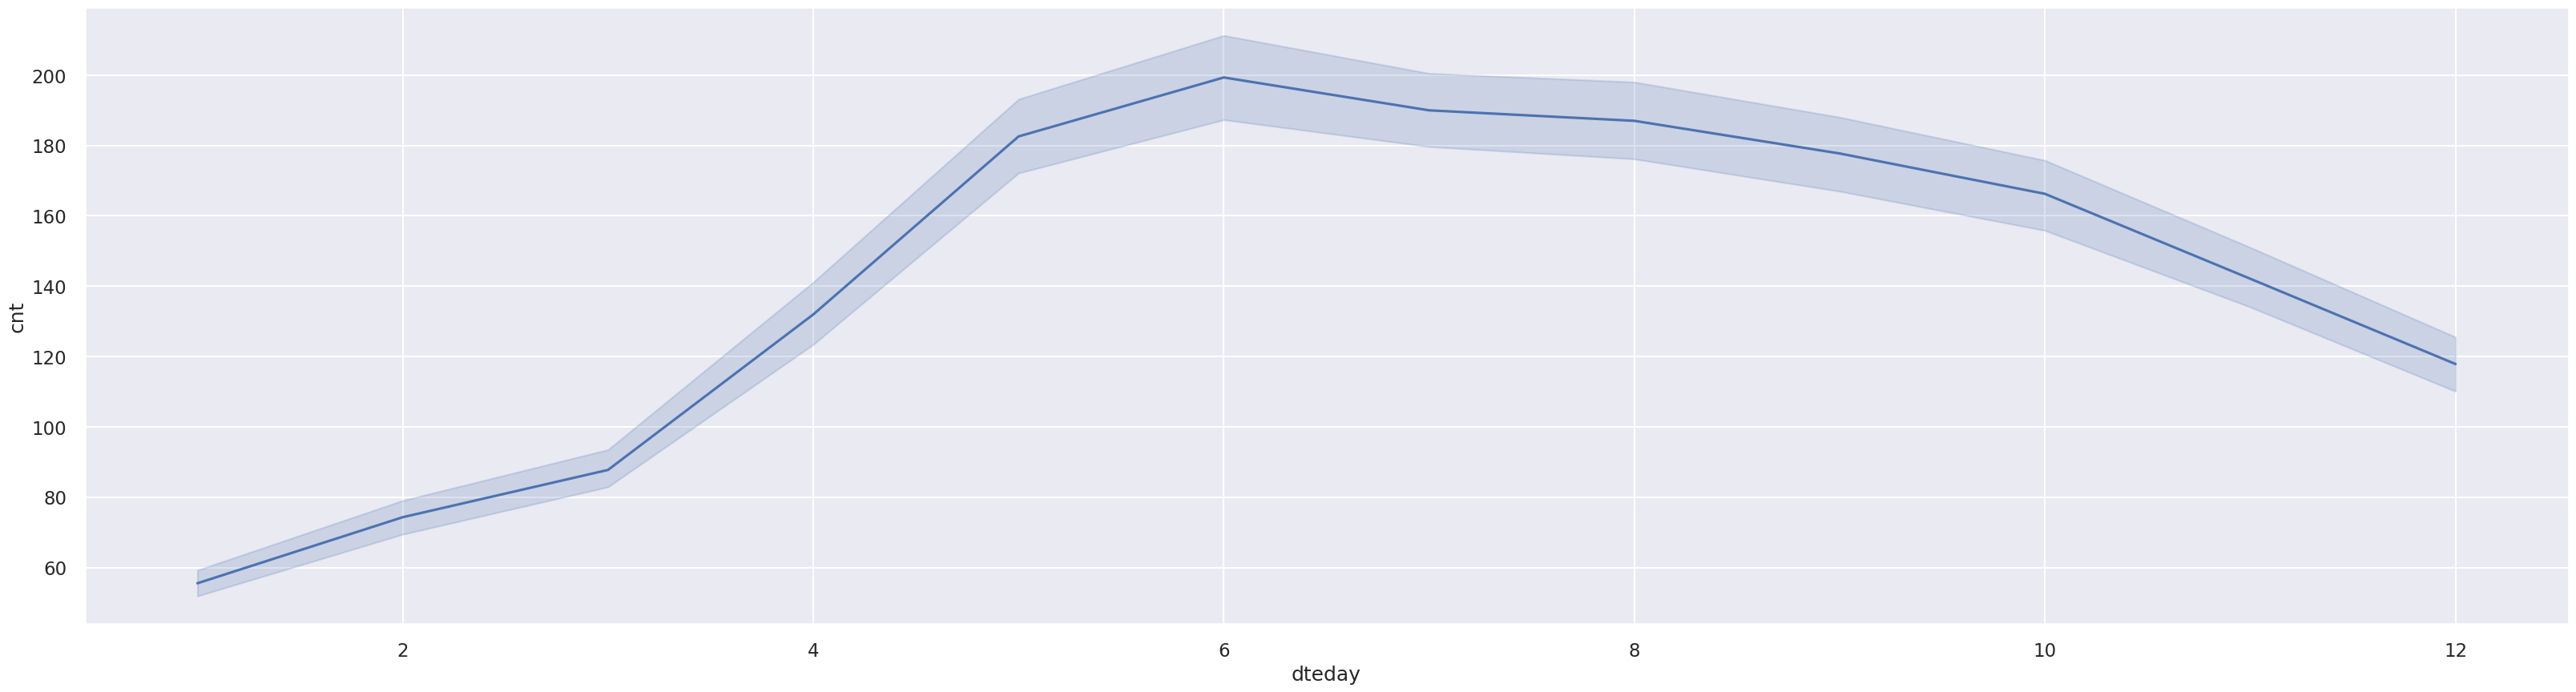

In [33]:
#折れ線グラフ

#見やすくする設定
sns.set(context='talk',font='Hiragino Maru Gothic Pro')
fig = plt.subplots(figsize=(40,10))

#月ごとの利用者数を表示 
sns.lineplot(data=train_month_df['cnt'])

In [29]:
#月ごとの合計、平均、最大値、最小値
train_df.resample('M').agg(['sum','mean','max','min']).head()

season                    yr               mnth                 hr  \
              sum      mean max min sum mean max min   sum mean max min   sum   
dteday                                                                          
2011-01-31    688  1.000000   1   1   0  0.0   0   0   688  1.0   1   1  8168   
2011-02-28    649  1.000000   1   1   0  0.0   0   0  1298  2.0   2   2  7649   
2011-03-31    990  1.356164   2   1   0  0.0   0   0  2190  3.0   3   3  8506   
2011-04-30   1438  2.000000   2   2   0  0.0   0   0  2876  4.0   4   4  8277   
2011-05-31   1488  2.000000   2   2   0  0.0   0   0  3720  5.0   5   5  8556   

                              holiday                   weekday                \
                 mean max min     sum      mean max min     sum      mean max   
dteday                                                                          
2011-01-31  11.872093  23   0      24  0.034884   1   0    2018  2.933140   6   
2011-02-28  11.785824  23   0      24  0.036980   1   0    1957  3.015408   6   
2011-03-31  11.652055  23   0       0  0.000000   0   0    2202  3.016438   6   
2011-04-30  11.511822  23   0      24  0.033380   1   0    2279  3.169680   6   
2011-05-31  11.500000  23   0      24  0.032258   1   0    2088  2.806452   6   

               workingday                   weathersit                    \
           min        sum      mean max min        sum      mean max min   
dteday                                                                     
2011-01-31   0        429  0.623547   1   0       1014  1.473837   4   1   
2011-02-28   0        436  0.671803   1   0        944  1.454545   3   1   
2011-03-31   0        541  0.741096   1   0       1135  1.554795   3   1   
2011-04-30   0        479  0.666203   1   0       1120  1.557719   3   1   
2011-05-31   0        504  0.677419   1   0       1065  1.431452   3   1   

              temp                           atemp                            \
               sum      mean   max   min       sum      mean     max     min   
dteday                                                                         
2011-01-31  135.82  0.197413  0.46  0.02  140.1854  0.203758  0.4545  0.0000   
2011-02-28  184.30  0.283975  0.66  0.06  185.4385  0.285730  0.6212  0.0758   
2011-03-31  241.80  0.331233  0.70  0.12  237.1618  0.324879  0.6364  0.0909   
2011-04-30  338.66  0.471015  0.76  0.24  328.3127  0.456624  0.6667  0.2273   
2011-05-31  429.46  0.577231  0.90  0.34  409.8053  0.550814  0.8333  0.3030   

               hum                      windspeed                         \
               sum      mean  max   min       sum      mean     max  min   
dteday                                                                     
2011-01-31  394.95  0.574055  1.0  0.21  135.8697  0.197485  0.5821  0.0   
2011-02-28  363.25  0.559707  1.0  0.08  148.9139  0.229451  0.8060  0.0   
2011-03-31  416.14  0.570055  1.0  0.00  169.5245  0.232225  0.6418  0.0   
2011-04-30  480.45  0.668220  1.0  0.22  175.5113  0.244105  0.6119  0.0   
2011-05-31  530.74  0.713360  1.0  0.24  134.8680  0.181274  0.6119  0.0   

               cnt                       
               sum        mean  max min  
dteday                                   
2011-01-31   38189   55.507267  249   1  
2011-02-28   48215   74.291217  327   1  
2011-03-31   64045   87.732877  336   1  
2011-04-30   94870  131.947149  530   1  
2011-05-31  135821  182.555108  611   1

In [36]:
#曜日ごとの売上金額の合計を表示
train_week_df = train_df.set_index(train_df.index.weekday)

#index名を曜日番号に変更
train_week_df.index.name = '曜日番号'

#各曜日の平均を表示
train_week_df.mean(level='曜日番号').sort_index()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
曜日番号,,,,,,,,,,,,,
0,2.528745,0.0,6.485020,11.590283,0.135223,1.0,0.864777,1.404858,0.498397,0.477759,0.646065,0.183908,145.927935
1,2.569558,0.0,6.621931,11.658756,0.000000,2.0,1.000000,1.495908,0.505336,0.485012,0.656702,0.186964,147.576105
2,2.500407,0.0,6.602116,11.542718,0.000000,3.0,1.000000,1.567128,0.502392,0.478921,0.683124,0.195553,137.647681
3,2.506939,0.0,6.669388,11.599184,0.019592,4.0,0.980408,1.467755,0.493273,0.471010,0.618678,0.207412,142.491429
4,2.510896,0.0,6.649718,11.556094,0.038741,5.0,0.961259,1.405973,0.476110,0.457345,0.623785,0.186433,146.897498
5,2.471519,0.0,6.530063,11.467563,0.000000,6.0,0.000000,1.409019,0.466060,0.448659,0.628434,0.196112,142.201741
6,2.508530,0.0,6.461413,11.604387,0.000000,0.0,0.000000,1.314379,0.482746,0.465032,0.647782,0.181801,143.845654


<AxesSubplot:xlabel='曜日番号', ylabel='cnt'>

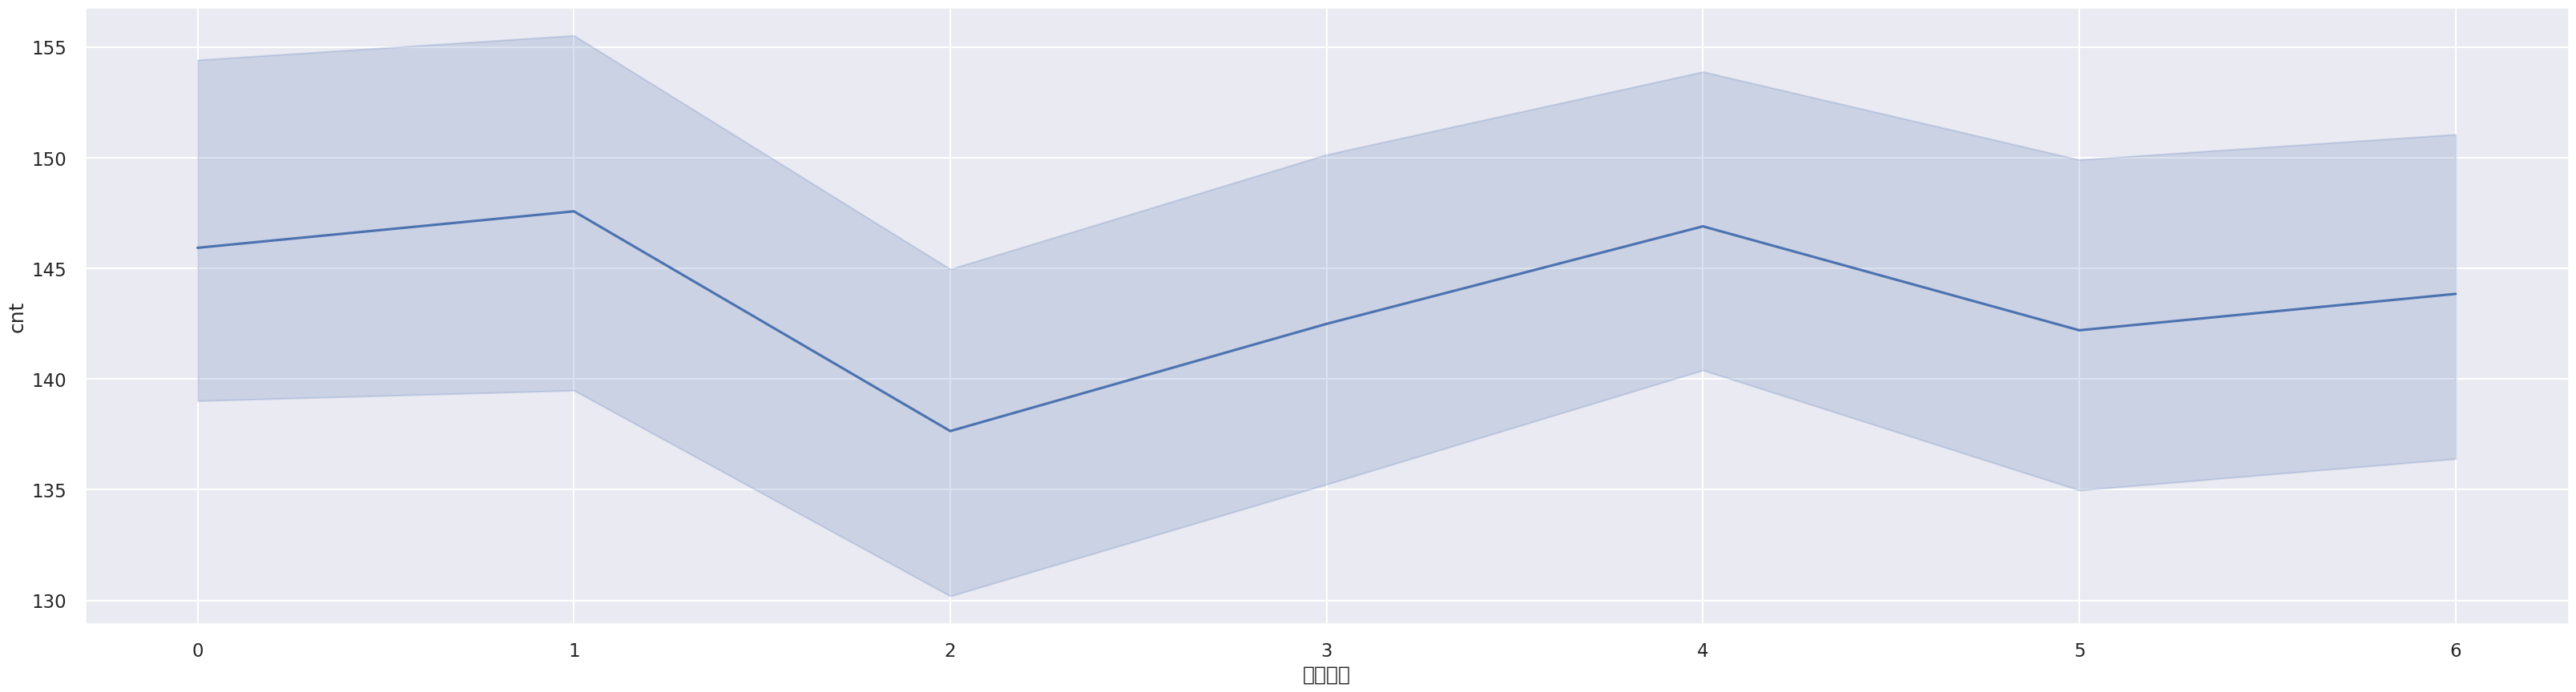

In [37]:
#折れ線グラフ

#見やすくする設定
sns.set(context='talk',font='Hiragino Maru Gothic Pro')
fig = plt.subplots(figsize=(40,10))

#曜日ごとの利用者数を表示 
sns.lineplot(data=train_week_df['cnt'])

In [55]:
#各曜日の平均を表示
train_week_df.mean(level='曜日番号').sort_index()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
曜日番号,,,,,,,,,,,,,
0,2.528745,0.0,6.485020,11.590283,0.135223,1.0,0.864777,1.404858,0.498397,0.477759,0.646065,0.183908,145.927935
1,2.569558,0.0,6.621931,11.658756,0.000000,2.0,1.000000,1.495908,0.505336,0.485012,0.656702,0.186964,147.576105
2,2.500407,0.0,6.602116,11.542718,0.000000,3.0,1.000000,1.567128,0.502392,0.478921,0.683124,0.195553,137.647681
3,2.506939,0.0,6.669388,11.599184,0.019592,4.0,0.980408,1.467755,0.493273,0.471010,0.618678,0.207412,142.491429
4,2.510896,0.0,6.649718,11.556094,0.038741,5.0,0.961259,1.405973,0.476110,0.457345,0.623785,0.186433,146.897498
5,2.471519,0.0,6.530063,11.467563,0.000000,6.0,0.000000,1.409019,0.466060,0.448659,0.628434,0.196112,142.201741
6,2.508530,0.0,6.461413,11.604387,0.000000,0.0,0.000000,1.314379,0.482746,0.465032,0.647782,0.181801,143.845654


5,6などの土曜、日曜の方が利用が多いと思ったが、曜日による違いはそんなになさそう。

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

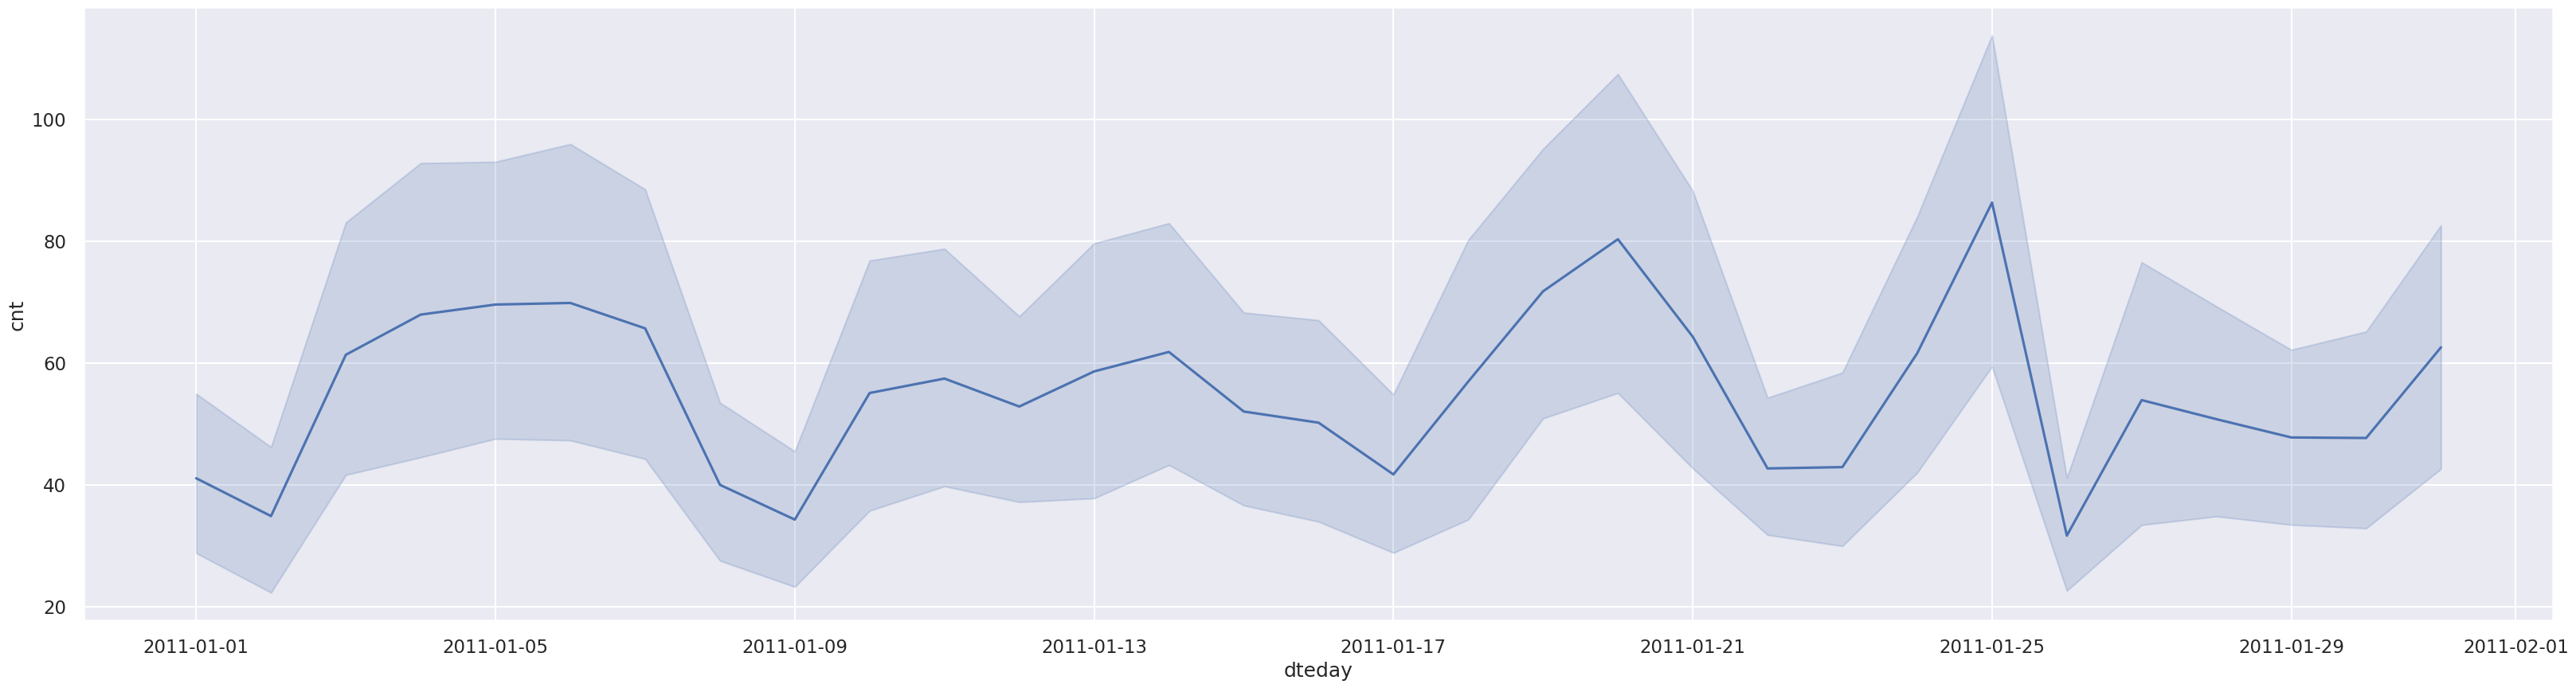

In [40]:
#折れ線グラフ

#見やすくする設定
sns.set(context='talk',font='Hiragino Maru Gothic Pro')
fig = plt.subplots(figsize=(40,10))

#2011年1月のみの利用者数を表示 
sns.lineplot(data=train_df['cnt']['2011-01'])

### idごとで可視化

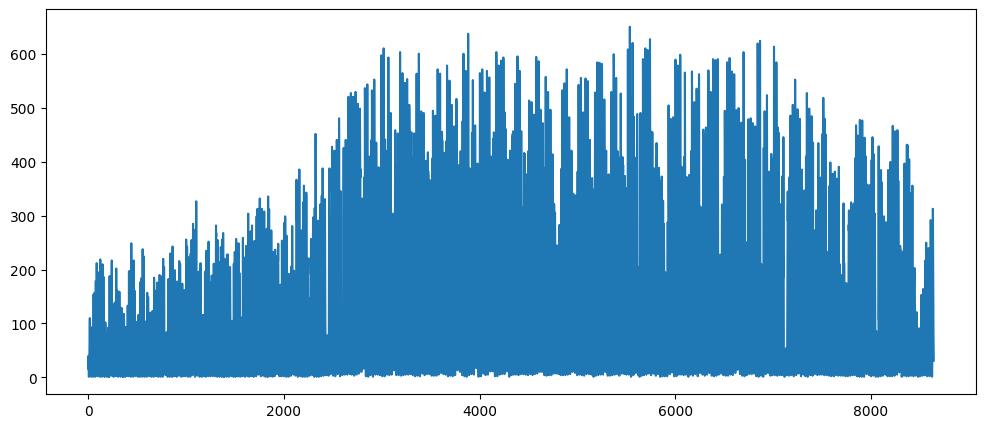

In [60]:
# 利用状況をプロットしてみる
train_df = pd.read_table('train.tsv')
plt.figure(figsize=(12,5))
plt.plot(train_df['id'],train_df['cnt'])

id2500以前は傾向が違う。  
レンタル自転車数を増やしたのか

### 相関関係

In [61]:
train_df.corr()[['cnt']]

,cnt
id,0.178084
season,0.221719
yr,NaN
mnth,0.179273
hr,0.407486
holiday,-0.022912
weekday,-0.004321
workingday,0.011704
weathersit,-0.143288
temp,0.451233


cntはhrと正の相関  
atempと正の相関  
hum(湿度)と負の相関  
→時間が遅くて、気温が高く、湿度が低いと利用者は増える。

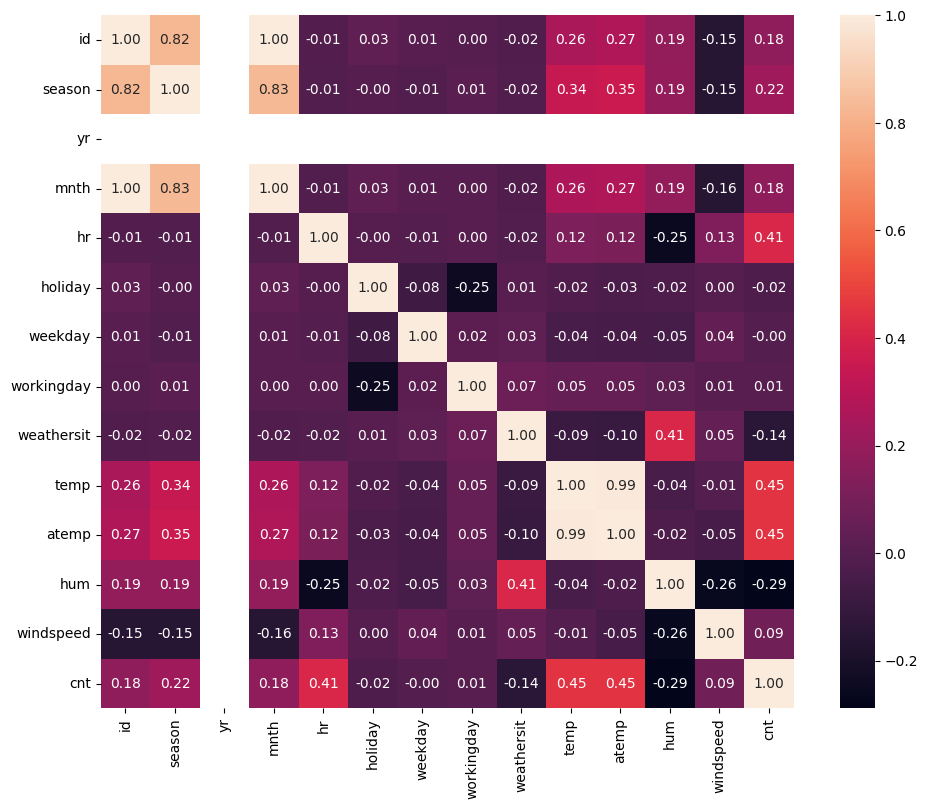

In [62]:
plt.figure(figsize=(12, 9))
sns.heatmap(train_df.corr(), annot=True, square=True, fmt='.2f')
plt.show()

### 相関関係を踏まえて、改めてクロス集計

#### 利用時間と曜日に絞って、表示

In [104]:
#各時間と曜日にまとめて、その平均を取る。
p_table2 = pd.pivot_table(data=train_df.loc[:,['cnt','weekday','hr']], index = 'hr', columns = 'weekday', aggfunc='mean')

#indexを時間、columnを曜日
p_table2.columns=['Sun.','Mon.','Tue.','Wed.','Thr.','Fri.','Sat.']
p_table2

,Sun.,Mon.,Tue.,Wed.,Thr.,Fri.,Sat.
hr,,,,,,,
0,95.085714,40.194444,27.000000,31.270270,36.729730,50.405405,90.405405
1,74.342857,22.944444,12.971429,13.135135,17.297297,23.567568,63.513514
2,61.085714,12.028571,7.621622,6.216216,8.694444,13.594595,50.864865
3,32.171429,6.558824,4.216216,4.166667,5.324324,6.189189,23.702703
4,8.970588,6.083333,5.540541,4.916667,5.108108,6.162162,7.567568
5,8.400000,19.916667,22.567568,21.459459,22.675676,21.756757,7.864865
6,13.771429,83.527778,101.324324,96.432432,94.000000,82.162162,19.837838
7,33.222222,235.527778,287.621622,258.054054,257.432432,225.135135,41.297297
8,78.916667,350.444444,410.621622,403.621622,400.675676,389.729730,99.081081


In [107]:
p_table3 = pd.pivot_table(data=train_df.loc[:,['cnt','weekday','hr']], index = 'weekday', columns = 'hr', aggfunc='mean')

#indexを曜日、columnを時間
p_table3.index=['Sun.','Mon.','Tue.','Wed.','Thr.','Fri.','Sat.']
p_table3

cnt                                                        \
hr           0          1          2          3         4          5    
Sun.  95.085714  74.342857  61.085714  32.171429  8.970588   8.400000   
Mon.  40.194444  22.944444  12.028571   6.558824  6.083333  19.916667   
Tue.  27.000000  12.971429   7.621622   4.216216  5.540541  22.567568   
Wed.  31.270270  13.135135   6.216216   4.166667  4.916667  21.459459   
Thr.  36.729730  17.297297   8.694444   5.324324  5.108108  22.675676   
Fri.  50.405405  23.567568  13.594595   6.189189  6.162162  21.756757   
Sat.  90.405405  63.513514  50.864865  23.702703  7.567568   7.864865   

                                                                              \
hr            6           7           8           9           10          11   
Sun.   13.771429   33.222222   78.916667  152.722222  249.833333  302.666667   
Mon.   83.527778  235.527778  350.444444  188.888889  131.388889  157.944444   
Tue.  101.324324  287.621622  410.621622  197.783784  115.972973  125.729730   
Wed.   96.432432  258.054054  403.621622  194.108108  108.189189  127.702703   
Thr.   94.000000  257.432432  400.675676  198.378378  113.000000  136.270270   
Fri.   82.162162  225.135135  389.729730  211.648649  134.270270  162.945946   
Sat.   19.837838   41.297297   99.081081  164.108108  234.432432  286.027027   

                                                                              \
hr            12          13          14          15          16          17   
Sun.  352.000000  360.833333  340.250000  328.666667  338.222222  301.305556   
Mon.  197.277778  195.472222  180.777778  186.555556  271.000000  479.611111   
Tue.  158.513514  160.459459  154.891892  170.540541  258.810811  493.270270   
Wed.  160.891892  149.729730  139.459459  140.351351  230.351351  448.459459   
Thr.  169.297297  164.378378  154.216216  161.486486  243.864865  439.405405   
Fri.  201.864865  208.135135  200.540541  222.351351  290.918919  431.783784   
Sat.  334.027027  331.243243  329.945946  340.729730  331.675676  301.459459   

                                                                              
hr            18          19          20          21          22          23  
Sun.  268.472222  235.638889  173.083333  133.527778  100.250000   66.777778  
Mon.  457.333333  329.555556  238.638889  177.611111  120.388889   64.944444  
Tue.  473.891892  328.486486  242.189189  189.567568  132.756757   72.081081  
Wed.  417.891892  309.513514  216.540541  164.594595  122.675676   74.945946  
Thr.  415.702703  296.675676  230.540541  174.297297  134.027027   88.378378  
Fri.  372.297297  262.702703  191.027027  157.162162  138.702703  111.945946  
Sat.  284.888889  235.472222  183.333333  154.472222  138.111111  112.861111

土曜と、日曜で利用者が異なる。祝日の利用日を多いはず。  
train,testデータの祝日に対応する日を日曜として保管してもいいかも

### カテゴリ変数の('weathersit')をダミー変数に変換する。

In [119]:
train_df.dtypes

id              int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

天気('weathersit')は  
1=晴,やや曇り  
2=薄い霧+曇り,霧+千切れ曇,霧+やや曇り,薄い霧  
3=小雪,小雨+雷雨+千切れ曇,小雨+千切れ曇  
4=大雨+凍雨+雷雨+霧,雪+濃い霧  
というデータ構成になっています。データ形式は整数(int)ですが、そのまま投入しても意味がありません。1から4をそれぞれゼロイチ(0,1)の2値にしてダミー変数にします。

In [120]:
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])

In [133]:
train_df_one_hot_encoded.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,weathersit_2,weathersit_3
2500,2501,2011-04-19,2,0,4,2,0,2,1,0.46,0.4545,0.67,0.2836,13,1,0,0
2501,2502,2011-04-19,2,0,4,3,0,2,1,0.48,0.4697,0.63,0.2239,3,1,0,0
2502,2503,2011-04-19,2,0,4,4,0,2,1,0.46,0.4545,0.67,0.0896,5,1,0,0
2503,2504,2011-04-19,2,0,4,5,0,2,1,0.46,0.4545,0.72,0.1940,18,0,1,0
2504,2505,2011-04-19,2,0,4,6,0,2,1,0.48,0.4697,0.67,0.0000,65,0,1,0


In [129]:
train_df['weathersit'].value_counts()

1    4180
2    1439
3     526
Name: weathersit, dtype: int64

In [130]:
test_df['weathersit'].value_counts()

1    5768
2    2326
3     638
4       2
Name: weathersit, dtype: int64

trainデータには大雨の4は無いが、testデータにはあるので、  
testでは、4を3に補完したうえで、ダミー変数に変換してやる。

# 検証１

# 学習
## XGBoost

In [3]:
#前処理なし
train_df = pd.read_table('train.tsv')
test_df = pd.read_table('test.tsv')

In [4]:
# XGBoostのライブラリのインポート
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [5]:
# xgboostモデルの作成
reg = xgb.XGBRegressor()

In [6]:
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df = train_df[train_df['id'] > 2500]

In [7]:
# 説明変数、目的変数を格納
X_train = train_df.drop(['id','dteday','cnt'], axis=1)
y_train = train_df['cnt']]
X_test = test_df.drop(['id','dteday'], axis=1)

In [118]:
# train dataをtrain dataとtest dataに分ける。
train_X, test_X, train_y, test_y = train_test_split(X_train, y_train, random_state=42, shuffle=False)


In [120]:
# ハイパーパラメータ探索
reg_cv = GridSearchCV(reg, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
reg_cv.fit(train_X, train_y)
print(reg_cv.best_params_, reg_cv.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'max_depth': 6, 'n_estimators': 50} 0.9023743487456599


In [121]:
# 改めて最適パラメータで学習
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## モデルの確認

In [123]:
# 学習データを使って予測
pred_test_y = reg.predict(test_X)

In [124]:
pred_test_y

array([259.3758 , 153.87988,  56.94194, ..., 144.47849, 103.82209,
        63.92534], dtype=float32)

<AxesSubplot: >

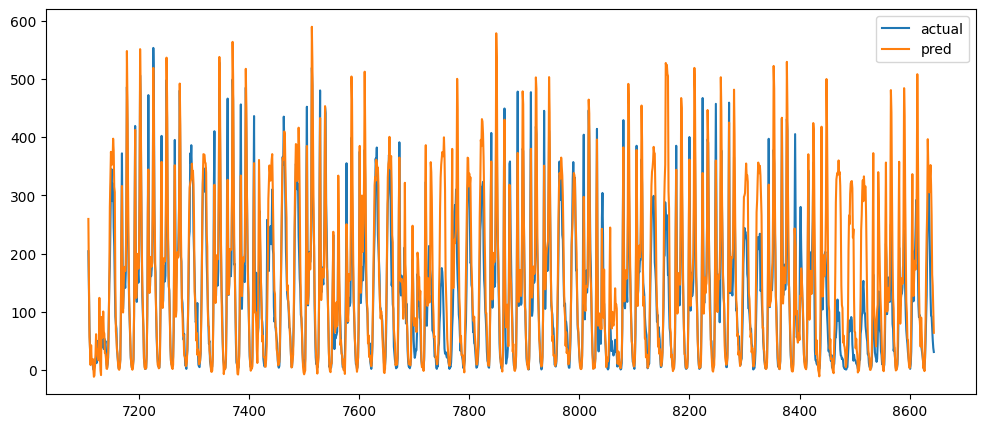

In [125]:
# 予測値が妥当か確認
train_value = y_train.values
_df = pd.DataFrame({'actual':test_y,'pred':pred_test_y})
_df.plot(figsize=(12,5))

おおむね、正しく予測出来てそう

### 特徴量の重要度確認

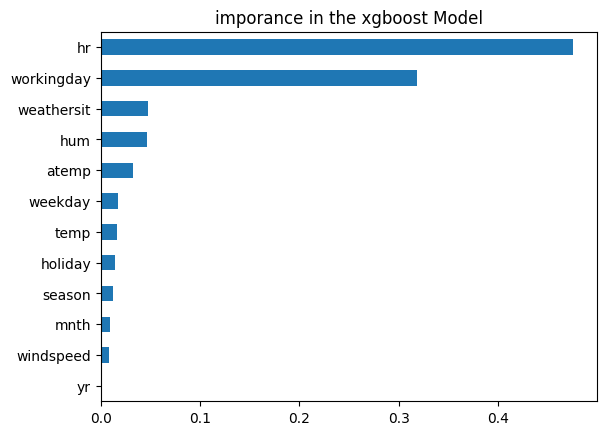

In [126]:
# feature importance のプロット
importances = pd.Series(reg.feature_importances_, index = X_train.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

時間と、曜日が大きくかかわっていることがわかる。

In [127]:
from sklearn.metrics import mean_squared_error
# RMSE計算
rmse = np.sqrt(mean_squared_error(test_y, pred_test_y))
print('RMSE : {:.3f}'.format(rmse))


RMSE : 70.500


わりと良さそう！

### 提出ファイルの作成

In [128]:
# テストデータに対し予測値の算出
pred_test = reg.predict(X_test)

In [129]:
pred_test

array([ 81.08319 ,  65.73449 ,  42.460697, ..., 122.549805,  70.946075,
        48.53842 ], dtype=float32)

In [130]:
sub = test_df.copy()
sub['cnt'] = pred_test
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,81.083191
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,65.734489
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,42.460697
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,26.842190
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,8.683386


In [131]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_01.csv', index=False, header = False)

In [132]:
sample_submit_01 = pd.read_csv('sample_submit_01.csv')
sample_submit_01.head(5)

,8646,81.08319
0,8647,65.734490
1,8648,42.460697
2,8649,26.842190
3,8650,8.683386
4,8651,8.956017


### 評価  
RMSE  119.0302645(125/1246位)  
→少し調節して、113.7184399に
最初にしては悪くない精度、  
特徴量を加えたり、別の学習モデルやアンサンブル学習などいろいろ出来そう。

# 検証２

### 回帰分析

In [137]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]

#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])


In [140]:
train_df_one_hot_encoded.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,weathersit_2,weathersit_3,weathersit_4
2500,2501,2011-04-19,2,0,4,2,0,2,1,0.46,0.4545,0.67,0.2836,13,1,0,0,0
2501,2502,2011-04-19,2,0,4,3,0,2,1,0.48,0.4697,0.63,0.2239,3,1,0,0,0
2502,2503,2011-04-19,2,0,4,4,0,2,1,0.46,0.4545,0.67,0.0896,5,1,0,0,0
2503,2504,2011-04-19,2,0,4,5,0,2,1,0.46,0.4545,0.72,0.1940,18,0,1,0,0
2504,2505,2011-04-19,2,0,4,6,0,2,1,0.48,0.4697,0.67,0.0000,65,0,1,0,0


In [141]:
train_df_one_hot_encoded.shape

(6145, 18)

In [142]:
#説明変数と目的変数を用意
#season,yr,mmth,holiday,weekday,workingday
X = train_df_one_hot_encoded[['hr','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
y = train_df_one_hot_encoded['cnt']

In [66]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [143]:
# train dataをtrain dataとtest dataに分けます。
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, shuffle=False)

# 線形回帰モデルを作成する（実はこれは機械学習です）
model = LR()

# trainの説明変数('train_X')と目的変数('train_y')をモデルに投入します。
model.fit(train_X, train_y)

# モデルの精度を確認します。
model.score(test_X, test_y)

0.1552923152694874

精度0.1552923152694874,,,
あまり高くはない。

In [144]:
test_X.shape,test_y.shape

((1537, 6), (1537,))

In [145]:
#trainデータの予測
y_test_pred = model.predict(test_X)
y_test_pred.shape

(1537,)

In [147]:
from sklearn.metrics import mean_squared_error
# RMSE計算
rmse = np.sqrt(mean_squared_error(y_test_pred, test_y))
print('RMSE : {:.3f}'.format(rmse))


RMSE : 106.637


### 提出ファイルの作成

In [148]:
#testデータの説明変数と目的変数を用意
#season,yr,mmth,holiday,weekday,workingday
X_test = test_df_one_hot_encoded[['hr','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
y_test_pred = model.predict(X_test)

In [149]:
y_test_pred

array([  9.90390065,  22.0856467 ,  19.85058967, ..., 195.79440279,
       204.47474736, 214.31965498])

In [150]:
sub = test_df.copy()
sub['cnt'] = y_test_pred
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,9.903901
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,22.085647
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,19.850590
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,24.827790
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,30.969554


In [151]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_02.csv', index=False, header = False)

In [152]:
sample_submit_02 = pd.read_csv('sample_submit_02.csv')
sample_submit_02.head(5)

,8646,9.90390064677537
0,8647,22.085647
1,8648,19.850590
2,8649,24.827790
3,8650,30.969554
4,8651,41.979025


### 評価  
RMSE  194.3392590(125/1246位)  
精度は高いとは言えない、  
特徴量を加えたり、別の学習モデルやアンサンブル学習などいろいろ出来そう。

# 検証３

### Deep learning  
## RNN

目的変数・・・利用者('cnt')  
説明変数・・・hr,workday,曜日('weekday')、温度('temp')、体感温度('atemp')、天気('weathersit')    
cntと相関関係のある変数を使う

In [153]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
train_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
train_df_one_hot_encoded.loc[train_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1
# 結果の件数を確認する
#train_df_one_hot_encoded['weekday2'].value_counts()
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]


#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
test_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
test_df_one_hot_encoded.loc[test_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1


In [154]:
train_df_one_hot_encoded['weekday2'].value_counts()

1    4407
0    1738
Name: weekday2, dtype: int64

In [156]:
train_df_one_hot_encoded.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,weathersit_2,weathersit_3,weathersit_4,weekday2
2500,2501,2011-04-19,2,0,4,2,0,2,1,0.46,0.4545,0.67,0.2836,13,1,0,0,0,1
2501,2502,2011-04-19,2,0,4,3,0,2,1,0.48,0.4697,0.63,0.2239,3,1,0,0,0,1
2502,2503,2011-04-19,2,0,4,4,0,2,1,0.46,0.4545,0.67,0.0896,5,1,0,0,0,1
2503,2504,2011-04-19,2,0,4,5,0,2,1,0.46,0.4545,0.72,0.1940,18,0,1,0,0,1
2504,2505,2011-04-19,2,0,4,6,0,2,1,0.48,0.4697,0.67,0.0000,65,0,1,0,0,1


必要なモジュールをインポート

In [157]:
import matplotlib.pyplot as plt
#tensorflowを用いる。
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

説明変数xと目的変数yを準備する。  

In [158]:
#必要な説明変数だけをとりだす
train_df_x = train_df_one_hot_encoded[['hr','workingday','weekday2','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
train_df_y = train_df_one_hot_encoded['cnt']
train_df_x.head()

,hr,workingday,weekday2,temp,atemp,weathersit_1,weathersit_2,weathersit_3
2500,2,1,1,0.46,0.4545,1,0,0
2501,3,1,1,0.48,0.4697,1,0,0
2502,4,1,1,0.46,0.4545,1,0,0
2503,5,1,1,0.46,0.4545,0,1,0
2504,6,1,1,0.48,0.4697,0,1,0


In [159]:
# defaultはtrain dataが75%、test dataが25%に分割されます。
# また時系列のデータなので、shuffleをFalseにします。
train_X, test_X, train_y, test_y = train_test_split(train_df_x, train_df_y, random_state=42, shuffle=False)

# input_dimに説明変数の数を入れます。
# Denseで層を設定します。
model = Sequential()
model.add(Dense(256, input_dim=8, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) #128のNordを50%落とす
model.add(Dense(1))

# 損失関数にmse、最適化関数にadamを採用
model.compile(loss='mse', optimizer='adam')

# モデルを学習させます
# epochsは学習回数24回(1時間ごとのデータで、24回で一日分のため)
#データ数(6483) x 学習回数
# batch_size データ数(6483)を細かく分ける
train_model = model.fit(train_X, train_y, epochs= 60, batch_size= 24, verbose=1, validation_data=(test_X, test_y))

Epoch 1/60
192/192 [==============================] - 1s 3ms/step - loss: 24023.7266 - val_loss: 15386.7480
Epoch 2/60
192/192 [==============================] - 0s 2ms/step - loss: 17070.4160 - val_loss: 14252.9111
Epoch 3/60
192/192 [==============================] - 0s 2ms/step - loss: 16554.1055 - val_loss: 14908.2822
Epoch 4/60
192/192 [==============================] - 0s 2ms/step - loss: 16440.3828 - val_loss: 12963.1143
Epoch 5/60
192/192 [==============================] - 0s 2ms/step - loss: 16084.5576 - val_loss: 13000.0713
Epoch 6/60
192/192 [==============================] - 0s 2ms/step - loss: 15554.5312 - val_loss: 11542.6846
Epoch 7/60
192/192 [==============================] - 0s 2ms/step - loss: 15315.5381 - val_loss: 10713.5918
Epoch 8/60
192/192 [==============================] - 0s 3ms/step - loss: 14699.9355 - val_loss: 11082.4219
Epoch 9/60
192/192 [==============================] - 0s 2ms/step - loss: 14448.4727 - val_loss: 10079.3633
Epoch 10/60
192/192 [=======

49/49 [==============================] - 0s 2ms/step
REG RMSE : 86.83


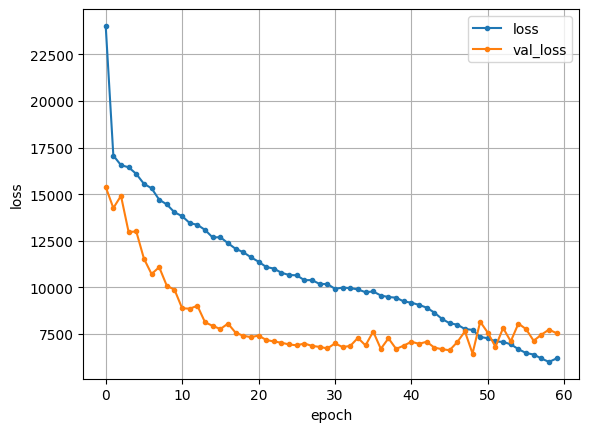

In [160]:
# 予測値を出力
y_pred = model.predict(test_X)

# 二乗誤差を出力
mse= mean_squared_error(test_y, y_pred)
print("REG RMSE : %.2f" % (mse** 0.5))

# epoch毎の予測値の正解データとの誤差を表しています
# バリデーションデータのみ誤差が大きい場合、過学習を起こしています

loss=train_model.history['loss']
val_loss=train_model.history['val_loss']
epochs=len(loss)

plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

epoch20あたりからlossが7500あたりで停滞  
val_lossが徐々に下がっていて、なかなか良いモデル。

In [165]:
from sklearn.metrics import mean_squared_error
# RMSE計算
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print('RMSE : {:.3f}'.format(rmse))


RMSE : 86.832


わるく無さそう。

In [166]:
#testデータの必要な変数だけをとりだす
test_df_x = test_df_one_hot_encoded[['hr','workingday','weekday2','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
test_df_x.head()

,hr,workingday,weekday2,temp,atemp,weathersit_1,weathersit_2,weathersit_3
0,0,0,0,0.36,0.3788,1,0,0
1,1,0,0,0.36,0.3485,1,0,0
2,2,0,0,0.32,0.3485,1,0,0
3,3,0,0,0.30,0.3333,1,0,0
4,4,0,0,0.28,0.3030,1,0,0


In [167]:
test_df_x.shape

(8734, 8)

In [168]:
# test dataにモデルを適用する
Y_test_pred = model.predict(test_df_x) #X_testデータを使って予測する

273/273 [==============================] - 0s 2ms/step


In [169]:
Y_test_pred

array([[92.98216 ],
       [62.593594],
       [34.43942 ],
       ...,
       [93.07214 ],
       [76.33465 ],
       [62.49991 ]], dtype=float32)

### 提出ファイルの作成

In [170]:
Y_test_pred.shape,test_df.shape

((8734, 1), (8734, 14))

In [171]:
sub = test_df.copy()
sub['cnt'] = Y_test_pred
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,92.982162
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,62.593594
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,34.439419
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,15.353641
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,8.348648


In [172]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_03.csv', index=False, header = False)

In [173]:
sample_submit_03 = pd.read_csv('sample_submit_03.csv')
sample_submit_03.head(5)

,8646,92.98216
0,8647,62.593594
1,8648,34.439420
2,8649,15.353641
3,8650,8.348648
4,8651,7.925747


### 評価  
RMSE  143.9651463(125/1246位)  
精度は高いとは言えない、  
特徴量を加えたり、別の学習モデルやアンサンブル学習などいろいろ出来そう。